# Clinical annotation for compounds found in patents
This notebook shows the overview on the FDA annotations for the compounds found in patents using DrugBank and clinical reserach annotation from ChEMBL

# Import Modules

In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Load data file

In [2]:
DATA_DIR = '../data/raw'
PROCESSED_DIR = '../data/processed/'
FIGURE_DIR = '../data/figures'

In [3]:
surechembl_df = pd.read_parquet(f'{DATA_DIR}/surechembl_dump.pq')
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


In [4]:
patent_cmps = set(surechembl_df['InChIKey'].unique())
len(patent_cmps)

10686744

In [5]:
# Withdrawn drugs
drugbank_withdrawn_df = pd.read_csv(
    f'{DATA_DIR}/drugbank_withdrawn_structure_links.csv.zip', compression='zip',
)

groupd_to_remove = [
    'illicit; withdrawn',
    'vet_approved; withdrawn'
]

mask = drugbank_withdrawn_df['Drug Groups'].isin(groupd_to_remove)
drugbank_withdrawn_df = drugbank_withdrawn_df[~mask][['DrugBank ID', 'Name', 'InChIKey']]

drugbank_withdrawn_df.head(2)

,DrugBank ID,Name,InChIKey
0,DB00106,Abarelix,AIWRTTMUVOZGPW-HSPKUQOVSA-N
1,DB00131,Adenosine phosphate,UDMBCSSLTHHNCD-KQYNXXCUSA-N


In [6]:
# Investigational drugs
drugbank_investigational_df = pd.read_csv(
    f'{DATA_DIR}/drugbank_investigational_structure_links.csv.zip', compression='zip',
    usecols=['DrugBank ID', 'Name', 'InChIKey']
)
drugbank_investigational_df.head(2)

,DrugBank ID,Name,InChIKey
0,DB00006,Bivalirudin,OIRCOABEOLEUMC-GEJPAHFPSA-N
1,DB00007,Leuprolide,GFIJNRVAKGFPGQ-LIJARHBVSA-N


In [7]:
chembl_phase_df = pd.read_parquet(f'{PROCESSED_DIR}/chembl.pq.gzip')

chembl_phase_df['clinical_phase'] = chembl_phase_df['clinical_phase'].map({
    np.nan: 'Preclinical',
    0.5: 'Phase 1',
    1: 'Phase 1',
    2: 'Phase 2',
    3: 'Phase 3',
    4: 'Approved',
    -1: 'Unknown'
})

mask = chembl_phase_df['inchikey'].isin(patent_cmps)
chembl_phase_df = chembl_phase_df[mask]

chembl_phase_df.head(2)

,chembl_id,clinical_phase,inchikey
12,CHEMBL6206,Preclinical,BYUCSFWXCMTYOI-ZRDIBKRKSA-N
24,CHEMBL6354,Preclinical,CKEYKKQODPYQPS-UHFFFAOYSA-P


# Get unique compounds

In [8]:
withdrawn_drugs = set(drugbank_withdrawn_df['InChIKey'].unique())
len(withdrawn_drugs)

270

In [9]:
investigational_drugs = set(drugbank_investigational_df['InChIKey'].unique())
len(investigational_drugs)

3918

In [10]:
clincal_stage_df = pd.DataFrame(chembl_phase_df['clinical_phase'].value_counts()).reset_index()
clincal_stage_df.columns = ['Phase', 'Count']
clincal_stage_df

,Phase,Count
0,Preclinical,307349
1,Unknown,5083
2,Approved,2929
3,Phase 2,1264
4,Phase 3,859
5,Phase 1,655


# Visualisation

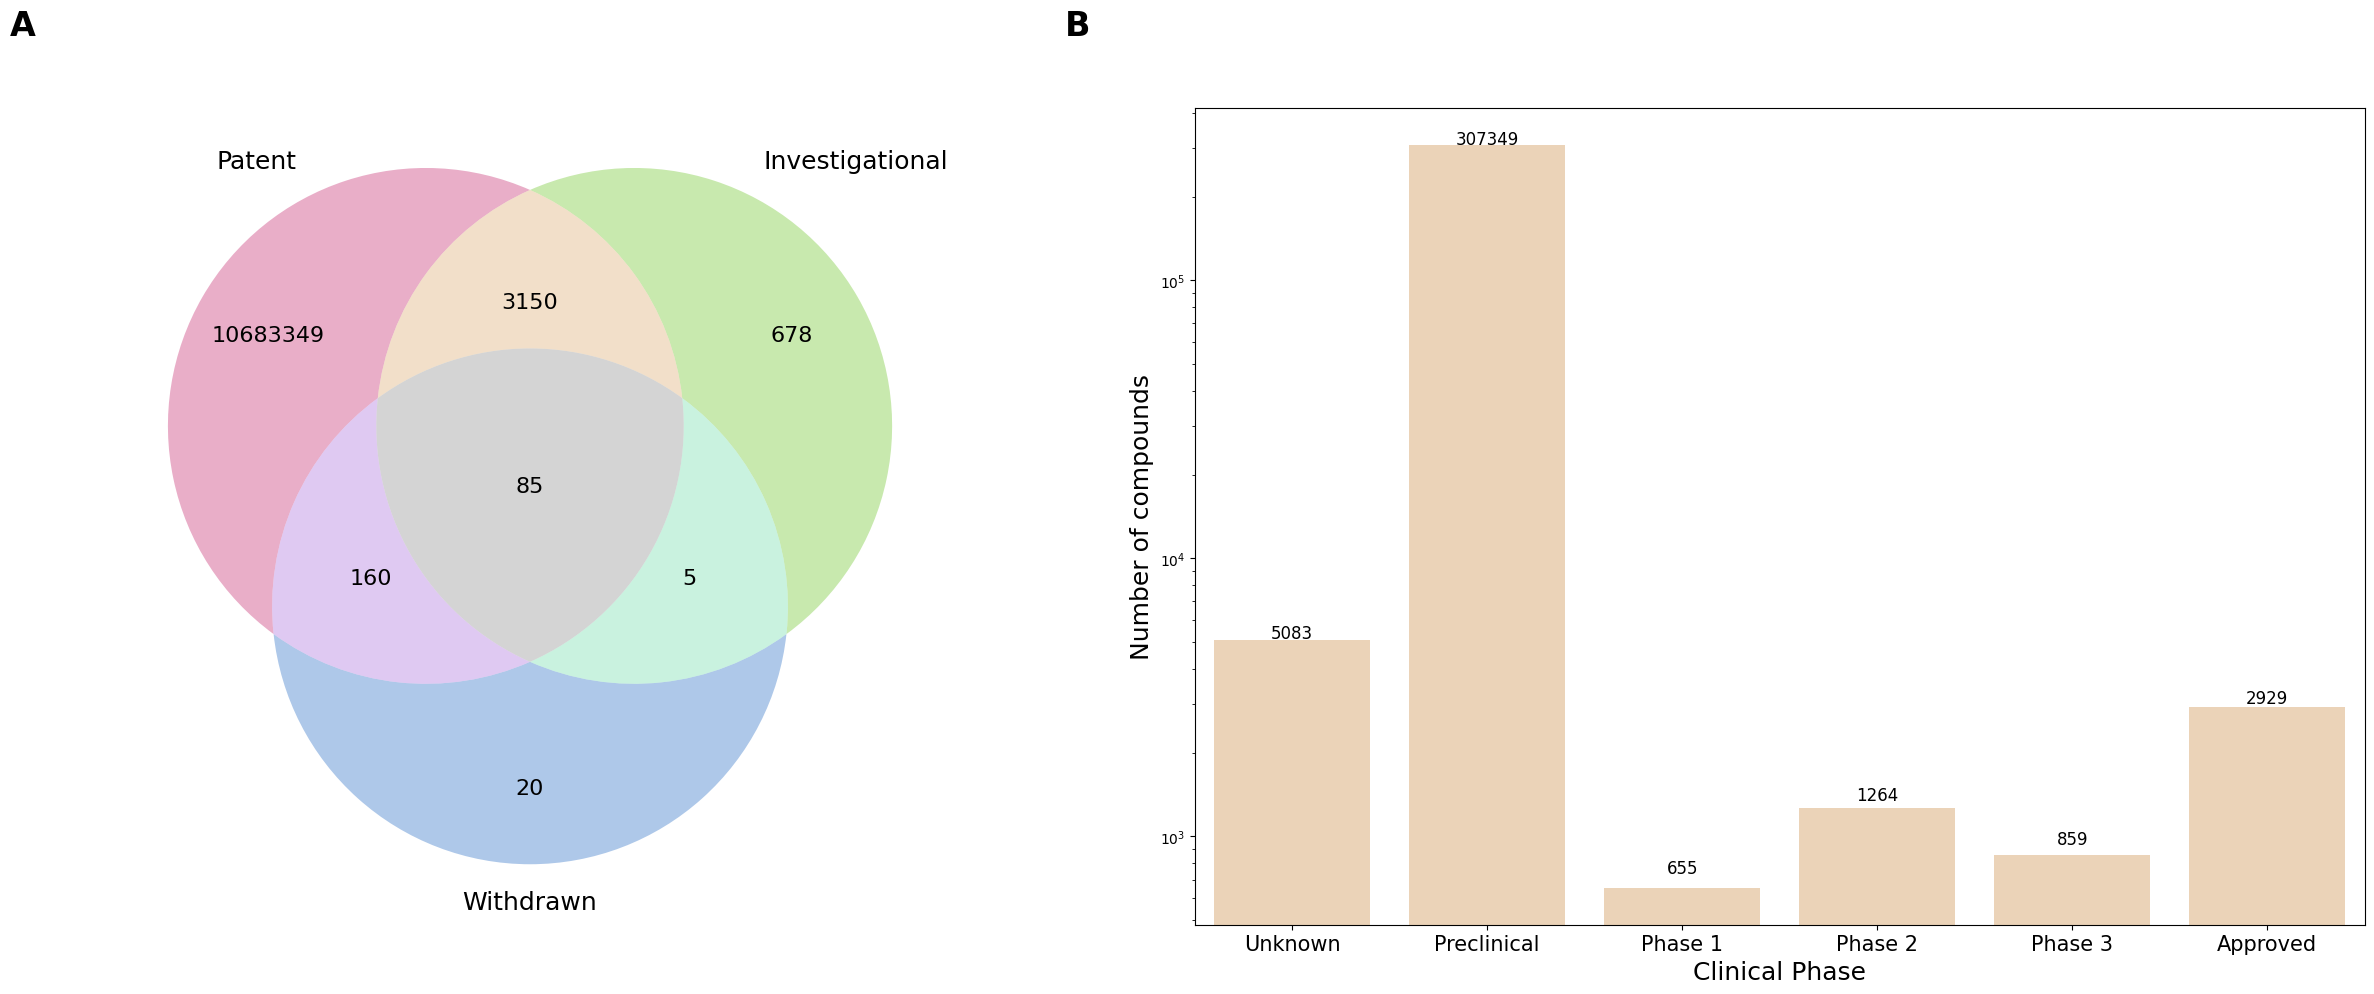

In [11]:
plt.figure(figsize = (25, 10))

plt.subplot(1, 2, 1)
v = venn3_unweighted(
    [patent_cmps, investigational_drugs, withdrawn_drugs], 
    set_labels = ('Patent', 'Investigational', 'Withdrawn'), 
    set_colors=('#c83576', '#76c835', '#3576c8')
)
for text in v.set_labels:  # External labels
    text.set_fontsize(18)
for text in v.subset_labels: # Internal labels in Venn
    text.set_fontsize(16)

plt.text(
    -0.1, 1.1, string.ascii_uppercase[0],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

plt.subplot(1, 2, 2)
order = ['Unknown', 'Preclinical', 'Phase 1', 'Phase 2', 'Phase 3', 'Approved']
ax = sns.barplot(
    data=clincal_stage_df, 
    x= 'Phase',
    y= 'Count',
    order=order,
    color='#f3d3b0'
)

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 80
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", fontsize=12)

plt.xticks(fontsize=15)
plt.ylabel('Number of compounds', fontsize=18)
plt.yscale('log')
plt.xlabel('Clinical Phase', fontsize=18)
plt.text(
    -0.1, 1.1, string.ascii_uppercase[1],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/figure_7.png', dpi=400)

plt.show()

# Statistics

In [12]:
total_compounds = patent_cmps.union(investigational_drugs).union(withdrawn_drugs)

In [13]:
drugbank_investigational_overlap = len(patent_cmps.intersection(investigational_drugs))
investigation_overlap_percent = (drugbank_investigational_overlap/len(total_compounds)) * 100
print(f'Drugbank investigational overlap: {drugbank_investigational_overlap} ({investigation_overlap_percent})')

Drugbank investigational overlap: 3235 (0.030269155954644734)


In [14]:
drugbank_withdrawn_overlap = len(patent_cmps.intersection(withdrawn_drugs))
withdrawn_overlap = (drugbank_withdrawn_overlap/len(total_compounds)) * 100
print(f'drugbank withdrawn overlap : {drugbank_withdrawn_overlap} ({withdrawn_overlap})')

drugbank withdrawn overlap : 245 (0.002292409029022553)


In [15]:
clincal_stage_df['percent'] = (clincal_stage_df['Count'] / clincal_stage_df['Count'].sum()) * 100
clincal_stage_df

,Phase,Count,percent
0,Preclinical,307349,96.608401
1,Unknown,5083,1.597729
2,Approved,2929,0.920667
3,Phase 2,1264,0.397311
4,Phase 3,859,0.270008
5,Phase 1,655,0.205885
